## Tutorial-05 Integration

**Step 1** 规划全局路径

Start planning
End point found
Path search completed


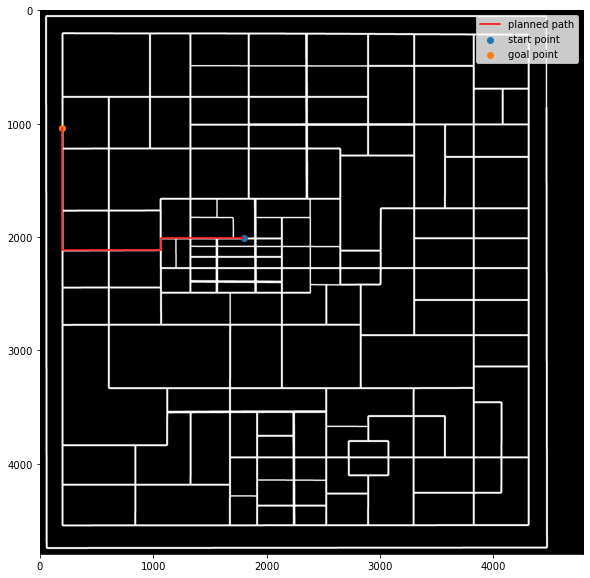

In [1]:
import cv2
import numpy as np

import matplotlib.pyplot as plt
import lib.a_star_planner as global_planner

print('Start planning')
map_image = cv2.imread("./data/roadnet.png", cv2.IMREAD_GRAYSCALE)

start_x = 198
start_y = 1037
end_x   = 1800
end_y   = 2010

a_star_planner = global_planner.AStar(start_x, start_y, end_x, end_y, map_image)
path = a_star_planner.update_planning()

plt.figure(figsize=(10, 10))
plt.imshow(map_image, cmap='gray')
if path is not None:
    path = np.array(path)
    plt.plot(path[:, 0], path[:, 1], 'r-', label='planned path')  
    plt.scatter(path[0, 0], path[0, 1], label='start point')
    plt.scatter(path[-1, 0], path[-1, 1], label='goal point')

plt.legend()
plt.show()

**Step 2** 根据全局路创建 Frenet 参考系

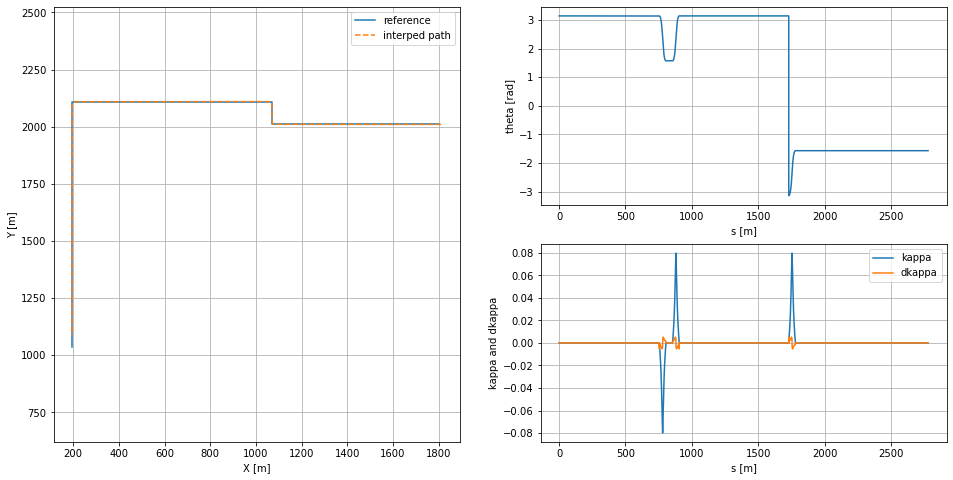

In [2]:
import lib.frenet_optimal_planner as fop

reference_x = np.mat(path[:, 0]).T
reference_y = np.mat(path[:, 1]).T

ref_path = fop.ReferencePath(reference_x, reference_y, 0.1)

plt.figure(2, figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(reference_x, reference_y, label='reference')
plt.plot(ref_path.interp_x_, ref_path.interp_y_, linestyle='dashed', label='interped path')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.axis('equal')
plt.grid(True)
plt.box(True)
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(ref_path.interp_s_, ref_path.interp_theta_)
plt.xlabel('s [m]')
plt.ylabel('theta [rad]')
plt.axis('tight')
plt.grid(True)
plt.box(True)

plt.subplot(2, 2, 4)
plt.plot(ref_path.interp_s_, ref_path.interp_kappa_, label='kappa')
plt.plot(ref_path.interp_s_, ref_path.interp_dkappa_, label='dkappa')
plt.xlabel('s [m]')
plt.ylabel('kappa and dkappa')
plt.axis('tight')
plt.grid(True)
plt.box(True)
plt.legend()

plt.show()

**Step 3** 测试 Frenet 坐标系下的五次多项式横 / 纵向采样

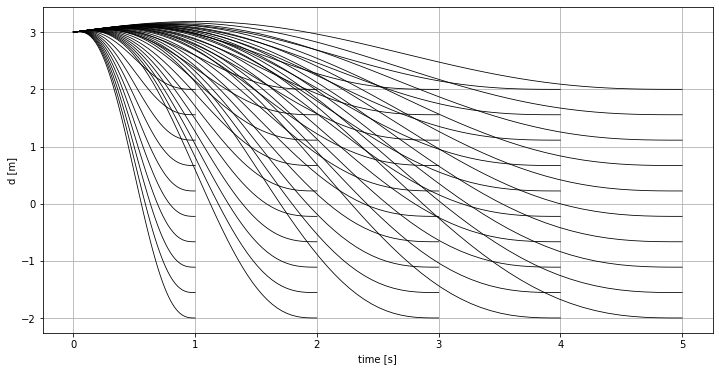

In [3]:
import lib.frenet_optimal_planner as poly

# 测试五次多项式采样
# 初始的横向状态
initial_d      = 3   # 初始的横向位移
initial_d_dot  = 0.3 # 初始的横向速度
initial_d_ddot = 0   # 初始的横向加速度
initial_time   = 0   # 采样的起始时间

# 终止的侧向状态
terminal_d_list = np.linspace(-2, 2, 10) # 采样的目标侧向位移
terminal_d_dot  = 0                     # 采样的终止侧向速度
terminal_d_ddot = 0                     # 采样点终止侧向加速度
terminal_time_list   = [1, 2, 3, 4, 5]  # 采样的终止时间

# 采样点的个数
sample_num = 50

plt.figure(3, figsize=(12, 6))
for terminal_time in terminal_time_list:
    sample_time = np.linspace(initial_time, terminal_time, sample_num)
    
    for terminal_d in terminal_d_list:
        lateral_trajectory = poly.QuinticPolynomial(
            initial_d , initial_d_dot , initial_d_ddot , 
            terminal_d, terminal_d_dot, terminal_d_ddot, 
            sample_time
        )
        
        plt.plot(sample_time, np.ravel(lateral_trajectory.p_), color='black', linewidth=0.8)
        
plt.grid(True)
plt.axis('tight')
plt.xlabel('time [s]')
plt.ylabel('d [m]')
plt.show()

**Step 4** 测试 Frenet 坐标系下四次多项式的纵向采样

Text(0, 0.5, 's_dot [m/s]')

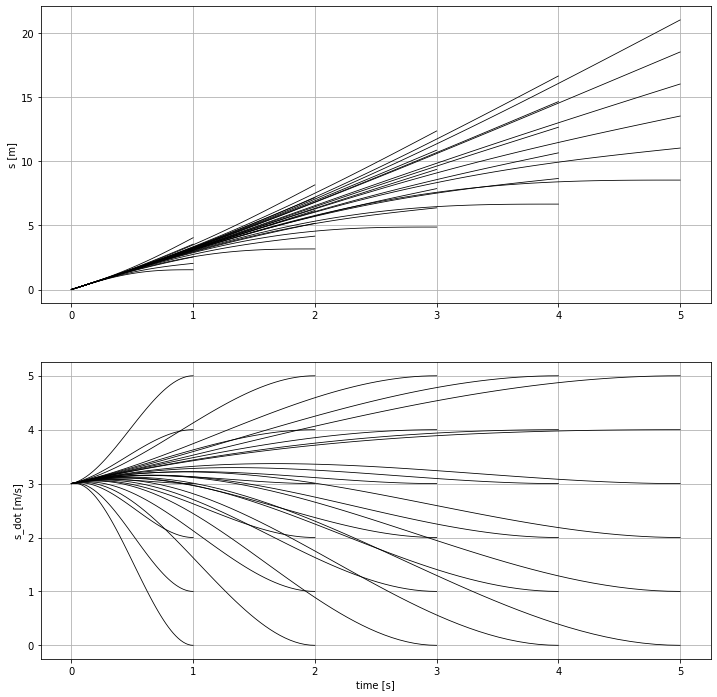

In [4]:
# 测试五次多项式采样
# 初始的横向状态
initial_s      =  0   # 起点累计弧长
initial_s_dot  =  3.0 # 初始纵向速度
initial_s_ddot =  0.5 # 初始的纵向加速度
initial_time   =  0   # 采样的起始时间

# 终止的侧向状态
terminal_s_dot_list = np.linspace(0, 5, 6) # 采样的目标车速
terminal_s_ddot  = 0                       # 采样的目标加速度
terminal_time_list   = [1, 2, 3, 4, 5]     # 采样的终止时间

# 采样点的个数
sample_num = 50

plt.figure(3, figsize=(12, 12))
ax_s     = plt.subplot(2, 1, 1)
ax_s_dot = plt.subplot(2, 1, 2)

for terminal_time in terminal_time_list:
    sample_time = np.linspace(initial_time, terminal_time, sample_num)
    
    for terminal_s_dot in terminal_s_dot_list:
        longitudinal_trajectory = poly.QuarticPolinomial(
            initial_s     , initial_s_dot  , initial_s_ddot, 
            terminal_s_dot, terminal_s_ddot, sample_time
        )
        
        ax_s.plot(sample_time, np.ravel(longitudinal_trajectory.p_), color='black', linewidth=0.8)
        ax_s_dot.plot(sample_time, np.ravel(longitudinal_trajectory.p_dot_), color='black', linewidth=0.8)
        
ax_s.grid(True)
ax_s_dot.grid(True)
ax_s.set_ylabel('s [m]')
ax_s_dot.set_xlabel('time [s]')
ax_s_dot.set_ylabel('s_dot [m/s]')

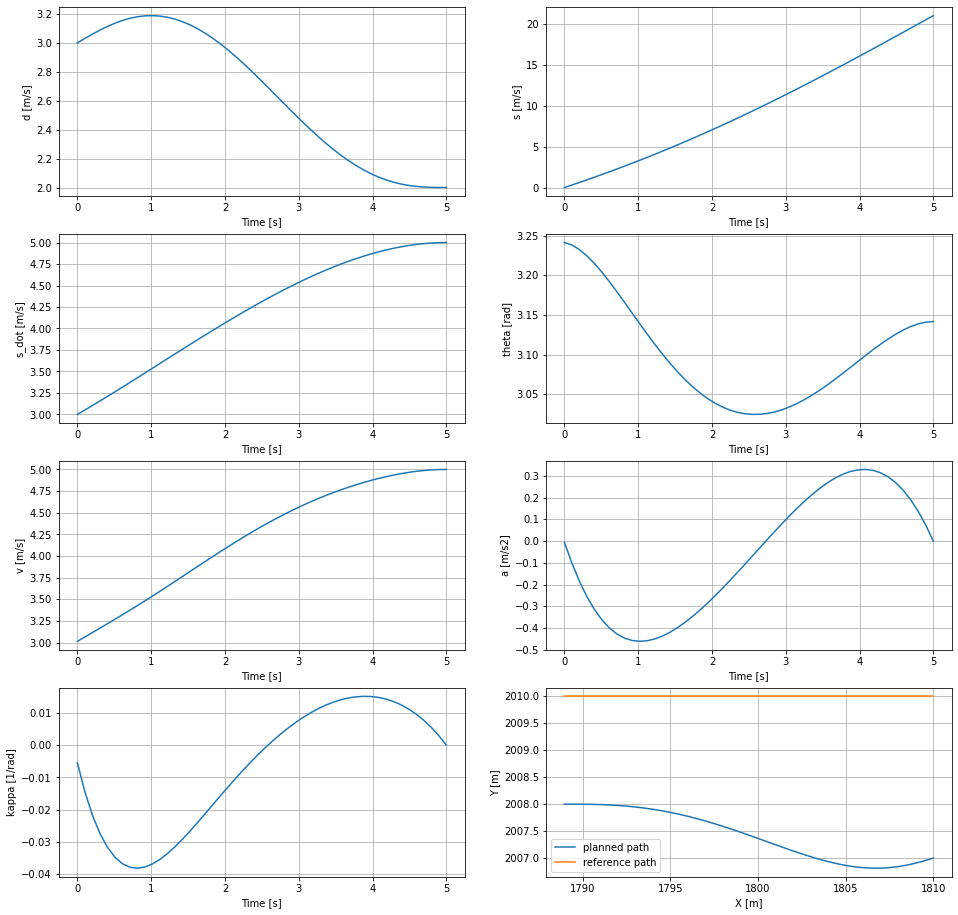

In [5]:
cartesian_trajectory = fop.Trajectory(longitudinal_trajectory, lateral_trajectory, sample_time, ref_path)
area = 30

plt.figure(4, figsize=(16, 16))
plt.subplot(4, 2, 1)
plt.plot(sample_time, np.ravel(lateral_trajectory.p_))
plt.grid(True)
plt.xlabel('Time [s]')
plt.ylabel('d [m/s]')

plt.subplot(4, 2, 2)
plt.plot(sample_time, np.ravel(longitudinal_trajectory.p_))
plt.grid(True)
plt.xlabel('Time [s]')
plt.ylabel('s [m/s]')

plt.subplot(4, 2, 3)
plt.plot(sample_time, np.ravel(longitudinal_trajectory.p_dot_))
plt.grid(True)
plt.xlabel('Time [s]')
plt.ylabel('s_dot [m/s]')

plt.subplot(4, 2, 4)
plt.plot(sample_time, cartesian_trajectory.theta_ )
plt.grid(True)
plt.xlabel('Time [s]')
plt.ylabel('theta [rad]')

plt.subplot(4, 2, 5)
plt.plot(sample_time, cartesian_trajectory.v_)
plt.grid(True)
plt.xlabel('Time [s]')
plt.ylabel('v [m/s]')

plt.subplot(4, 2, 6)
plt.plot(sample_time, cartesian_trajectory.a_)
plt.grid(True)
plt.xlabel('Time [s]')
plt.ylabel('a [m/s2]')

plt.subplot(4, 2, 7)
plt.plot(sample_time, cartesian_trajectory.kappa_)
plt.grid(True)
plt.xlabel('Time [s]')
plt.ylabel('kappa [1/rad]')

plt.subplot(4, 2, 8)
plt.plot(cartesian_trajectory.x_, cartesian_trajectory.y_, label='planned path')
plt.plot(cartesian_trajectory.x_ref_, cartesian_trajectory.y_ref_, label='reference path')
plt.grid(True)
plt.legend()
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

plt.show()

Processing ...
Finish


(585.0, 1585.0)

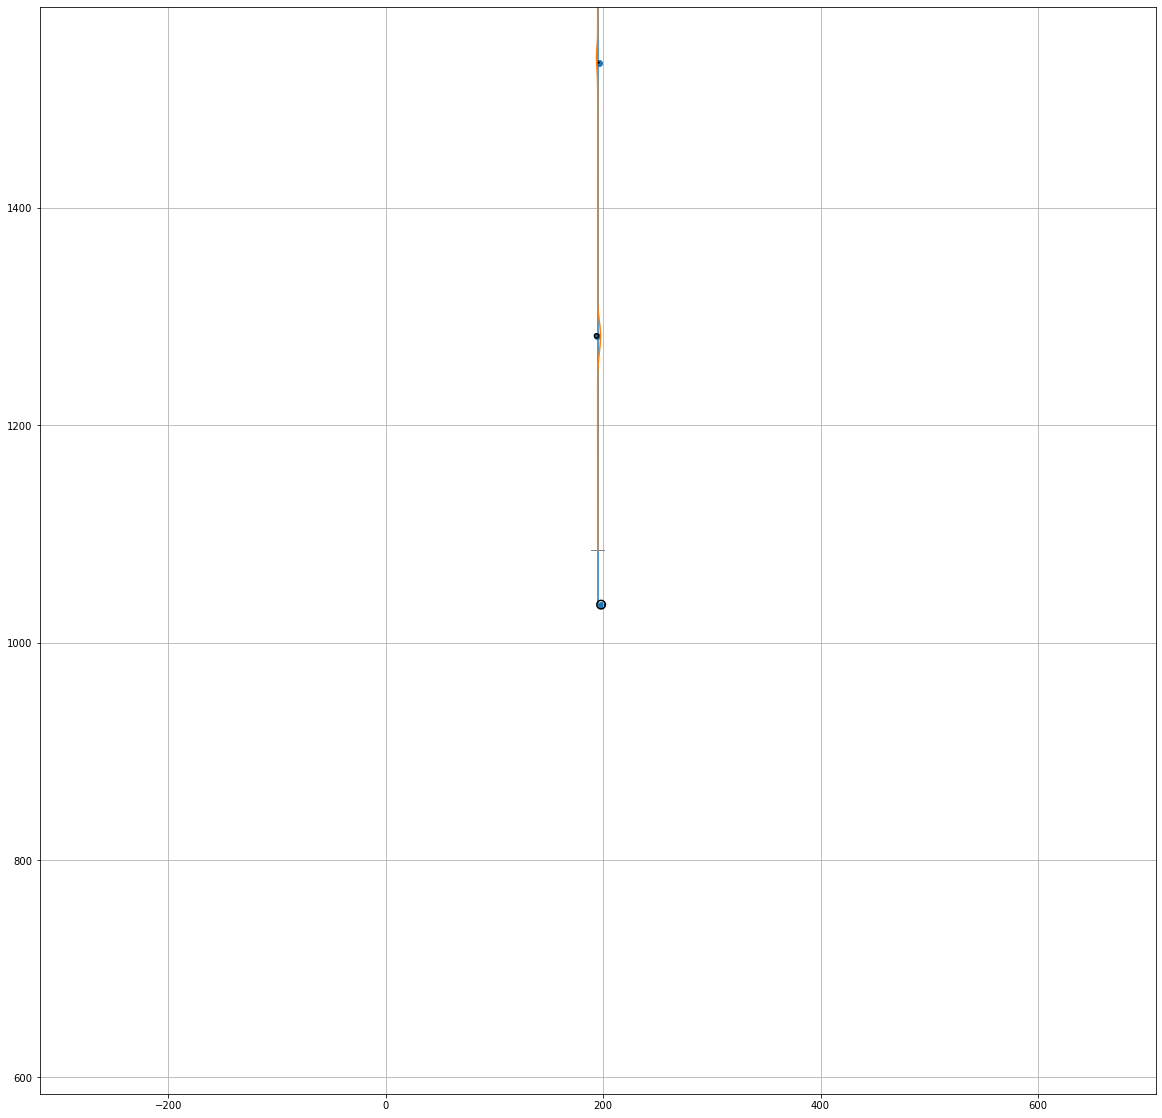

In [6]:
import math

import lib.data_struct as struct
import lib.param_parser as parser

def plot_circle(center_x, center_y, radius, circle_color):
    theta = np.linspace(0, 2*math.pi, 100)
    x = radius * np.cos(theta) + center_x
    y = radius * np.sin(theta) + center_y
    
    plt.plot(x, y, color=circle_color)
    
    return

# 初始化车辆外形
vehicle_geometry = fop.VehicleGeometry(l=3, w=2)

# 生成测试场景
obs_index_gap  = 10
obs_index_list = np.floor(np.arange(obs_index_gap, len(reference_x), obs_index_gap))
obs_x = np.zeros_like(obs_index_list)
obs_y = np.zeros_like(obs_index_list)
obs_r = np.zeros_like(obs_index_list)

obs_list = []

for i in range(len(obs_index_list)):
    index = int(obs_index_list[i])
    obs_x[i] = reference_x[index] + np.random.uniform(-8, 8, 1)
    obs_y[i] = reference_y[index] + np.random.uniform(-8, 8, 1)
    obs_r[i] = np.random.uniform(0, 4, 1)
    
    obs_pose  = struct.Transform(obs_x[i], obs_y[i], 0)
    obs_state = struct.StaticObstacle(obs_pose, obs_r[i])

    obs_list.append(obs_state)
    
# 设置车辆初始状态
initial_x     = ref_path.interp_x_[0, 0]
initial_y     = ref_path.interp_y_[0, 0]
initial_theta = ref_path.interp_theta_[0, 0]

initial_kappa = 0
initial_v     = 0
initial_a     = 0

vehicle_pose  = struct.Transform(initial_x, initial_y, initial_theta)
vehicle_state = struct.State(vehicle_pose, initial_v, initial_a, initial_kappa)

# 设置仿真条件
total_sim_time = 100
sample_time    = 0.1
sim_time       = np.arange(0, total_sim_time, sample_time)

# 初始化记录轨迹的空数组
actual_x_list = []
actual_y_list = []
actual_v_list = []
actual_theta_list = []

# 规划一个轨迹
parameters = parser.Parameters("./config/params.ini")
frenet_state   = fop.transform_cartesian_to_frenet(vehicle_state, ref_path)
planner        = fop.FrenetOptimalPlanner(ref_path, parameters)

optimal_trajectory, valid_trajectory, trajectory_list = planner.update_planning(frenet_state, vehicle_geometry, obs_list)

print("Processing ...")
for i in range(len(sim_time)):
    if valid_trajectory != [] and len(optimal_trajectory.s_) > 2:
        index = 1
    else:
        print("No valid path")
        break
    
    if optimal_trajectory.s_[0, 0] >= ref_path.interp_s_[-1]:
        actual_x_list.append(optimal_trajectory.x_[0, 0])
        actual_y_list.append(optimal_trajectory.y_[0, 0])
        actual_v_list.append(optimal_trajectory.v_[0, 0])
        actual_theta_list.append(optimal_trajectory.theta_[0, 0])
        print("Finish")
        break
    
    actual_x_list.append(optimal_trajectory.x_[0, 0])
    actual_y_list.append(optimal_trajectory.y_[0, 0])
    actual_v_list.append(optimal_trajectory.v_[0, 0])
    actual_theta_list.append(optimal_trajectory.theta_[0, 0])
    
    frenet_state = struct.FrenetState(optimal_trajectory.s_[index, 0], 
                                      optimal_trajectory.s_dot_[index, 0], 
                                      optimal_trajectory.s_ddot_[index, 0], 
                                      optimal_trajectory.d_[index, 0], 
                                      optimal_trajectory.d_dot_[index, 0], 
                                      optimal_trajectory.d_ddot_[index, 0])
    
    optimal_trajectory, valid_trajectory, trajectory_list = planner.update_planning(frenet_state, 
                                                                   vehicle_geometry, 
                                                                   obs_list)
    
# 绘图
plt.figure(10, figsize=(20, 20))
plt.plot(reference_x, reference_y)
plt.scatter(obs_x, obs_y)

for i in range(len(obs_index_list)):
    plot_circle(obs_x[i], obs_y[i], obs_r[i], 'black')

for trajectory in trajectory_list:
    plt.plot(trajectory.x_, trajectory.y_, color='gray', linewidth=0.5)

plt.plot(actual_x_list, actual_y_list)
plt.axis('equal')
plt.grid(True)

area = 500
plt.xlim(actual_x_list[-1] - area, actual_x_list[-1] + area)
plt.ylim(actual_y_list[-1] - area, actual_y_list[-1] + area)


(-415.0, 2585.0)

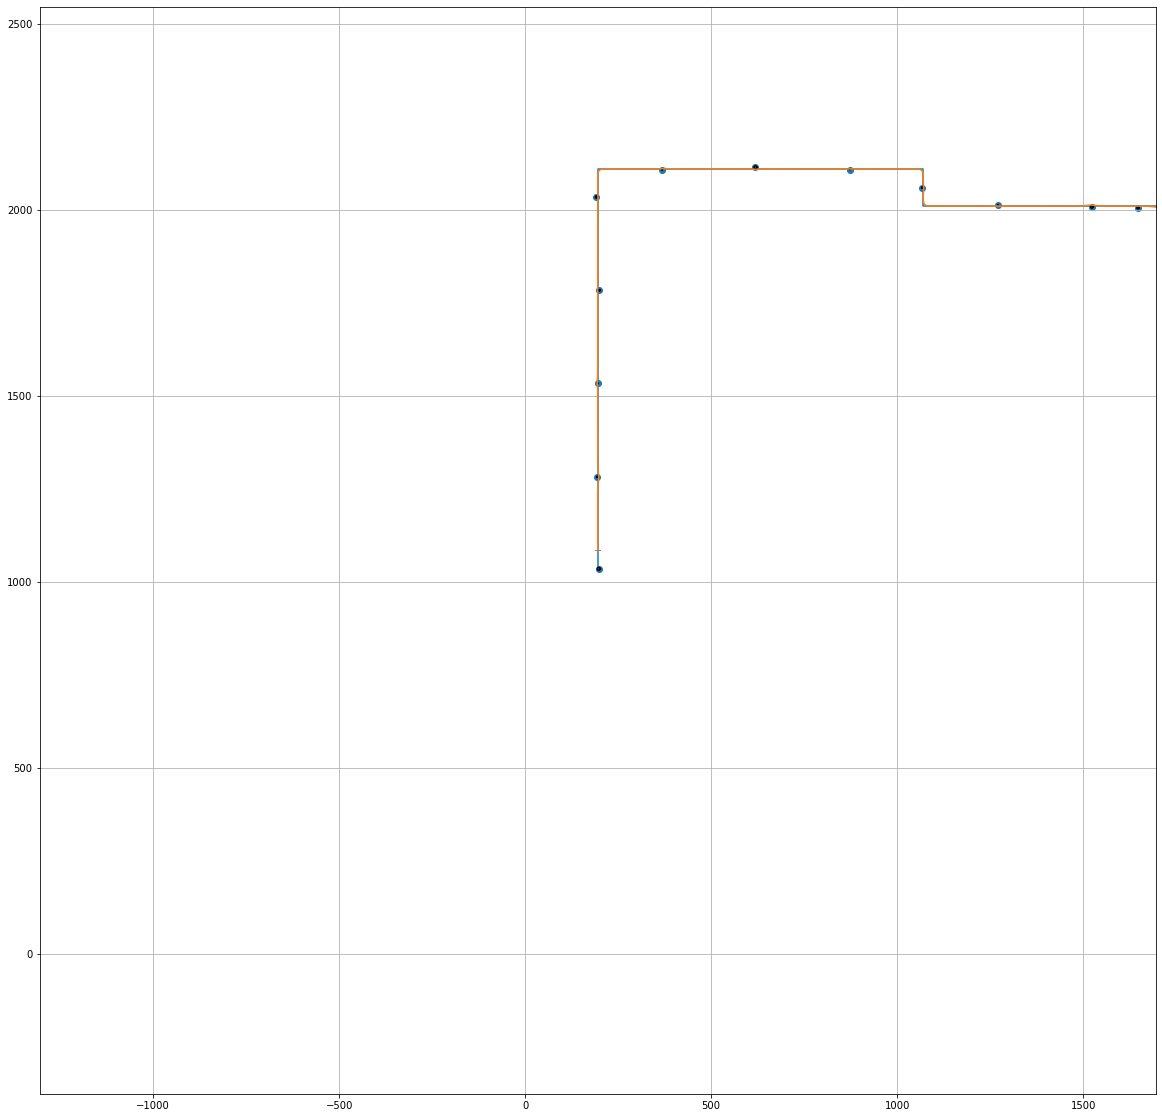

In [9]:
# 绘图
plt.figure(10, figsize=(20, 20))
plt.plot(reference_x, reference_y)
plt.scatter(obs_x, obs_y)

for i in range(len(obs_index_list)):
    plot_circle(obs_x[i], obs_y[i], obs_r[i], 'black')

for trajectory in trajectory_list:
    plt.plot(trajectory.x_, trajectory.y_, color='gray', linewidth=0.5)

plt.plot(actual_x_list, actual_y_list)
plt.axis('equal')
plt.grid(True)

area = 1700
plt.xlim(actual_x_list[-1] - area, actual_x_list[-1] + area)
plt.ylim(actual_y_list[-1] - area, actual_y_list[-1] + area)